## Research Question
In this project, I want to predict if a patient is healthy or has some diagnosis based on the PERG-IOBA dataset. The target variable will therefore be binary -> diagnosis or not.

## Imports

In [67]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, silhouette_score, adjusted_rand_score 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


## Import CSV Data

In [43]:
results_df = pd.read_csv("./a-comprehensive-dataset-of-pattern-electroretinograms-for-ocular-electrophysiology-research-the-perg-ioba-dataset-1.0.0/csv/participants_info.csv")

In [44]:
# merging the data from all the files together into one dictionary of dataframes
features_df = {}
for file in os.listdir(os.fsencode("./data/")):
    filename = os.fsdecode(file)
    if filename != "participants_info.csv": 
        name, _ = os.path.splitext(filename)
        features_df[name] = pd.read_csv("data/" + filename)

## Data Exploration & Preprocessing

### Explore Features

In [45]:
results_df.head()

,id_record,date,age_years,sex,diagnosis1,diagnosis2,diagnosis3,va_re_logMar,va_le_logMar,unilateral,rep_record,comments
0,1,2016-09-15,13,Male,Normal,NaN,NaN,-0.08,0.06,NaN,NaN,NaN
1,2,2005-09-15,13,Female,Congenital stationary night blindness,NaN,NaN,0.18,0.16,NaN,NaN,NaN
2,3,2019-08-08,49,Female,Orbital ischemia,Systemic disorder with ocular manifestations,NaN,0.26,0.00,NaN,Id:0329 - Id:0154 - Id:0049 - Id:0271,NaN
3,4,2004-12-16,43,Female,Retinitis pigmentosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2016-07-13,47,Female,Normal,NaN,NaN,0.10,0.10,NaN,NaN,NaN


In [46]:
features_df["0001"]

,TIME_1,RE_1,LE_1
0,2016-09-15 09:40:21.0000,0.0,0.0
1,2016-09-15 09:40:21.0006,-0.1,0.1
2,2016-09-15 09:40:21.0012,-0.2,0.2
3,2016-09-15 09:40:21.0018,-0.2,0.4
4,2016-09-15 09:40:21.0024,-0.2,0.6
...,...,...,...
250,2016-09-15 09:40:21.1476,-1.3,2.9
251,2016-09-15 09:40:21.1482,-1.5,2.6
252,2016-09-15 09:40:21.1487,-1.8,2.4
253,2016-09-15 09:40:21.1493,-1.8,2.3


### Drop Features
I am focusing on the target of the first diagnosis (Normal vs. Abnormal). Therefore, the second and third diagnosis columns are dropped. Furthermore, date and comments will not be considered for the prediction. As for multiple records for one patient (rep_records), they will be treated as single records and their combination will not be considered.

In [47]:
results_df.drop(axis=1,labels=["comments", "diagnosis2", "diagnosis3", "rep_record", "date"], inplace=True)
results_df.rename(columns={"diagnosis1": "diagnosis"}, inplace=True)
results_df

,id_record,age_years,sex,diagnosis,va_re_logMar,va_le_logMar,unilateral
0,1,13,Male,Normal,-0.08,0.06,NaN
1,2,13,Female,Congenital stationary night blindness,0.18,0.16,NaN
2,3,49,Female,Orbital ischemia,0.26,0.00,NaN
3,4,43,Female,Retinitis pigmentosa,NaN,NaN,NaN
4,5,47,Female,Normal,0.10,0.10,NaN
...,...,...,...,...,...,...,...
331,332,43,Male,Autoimmune retinopathy,0.02,0.00,NaN
332,333,4,Male,X linked retinoschisis,1.00,0.52,NaN
333,334,14,Male,Normal,-0.10,-0.06,NaN
334,335,23,Female,Retinitis pigmentosa,0.00,0.00,NaN


### Convert to Binary
- sex: male 0, female 1
- diagnosis: normal 0, abnormal 1

In [48]:
one_hot_gender = pd.get_dummies(data=results_df["sex"], dtype=int).drop(columns=["Male"])
one_hot_gender

results_df["sex"] = results_df["sex"].replace({"Female": 1, "Male": 0})

results_df["diagnosis"] = results_df["diagnosis"].replace("Normal", 0)
results_df.loc[results_df["diagnosis"] != 0, "diagnosis"] = 1

/tmp/ipykernel_19248/2412067962.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df["sex"] = results_df["sex"].replace({"Female": 1, "Male": 0})


In [49]:
results_df['diagnosis'] = results_df['diagnosis'].astype('int8')

### Plot histograms for features in results_df


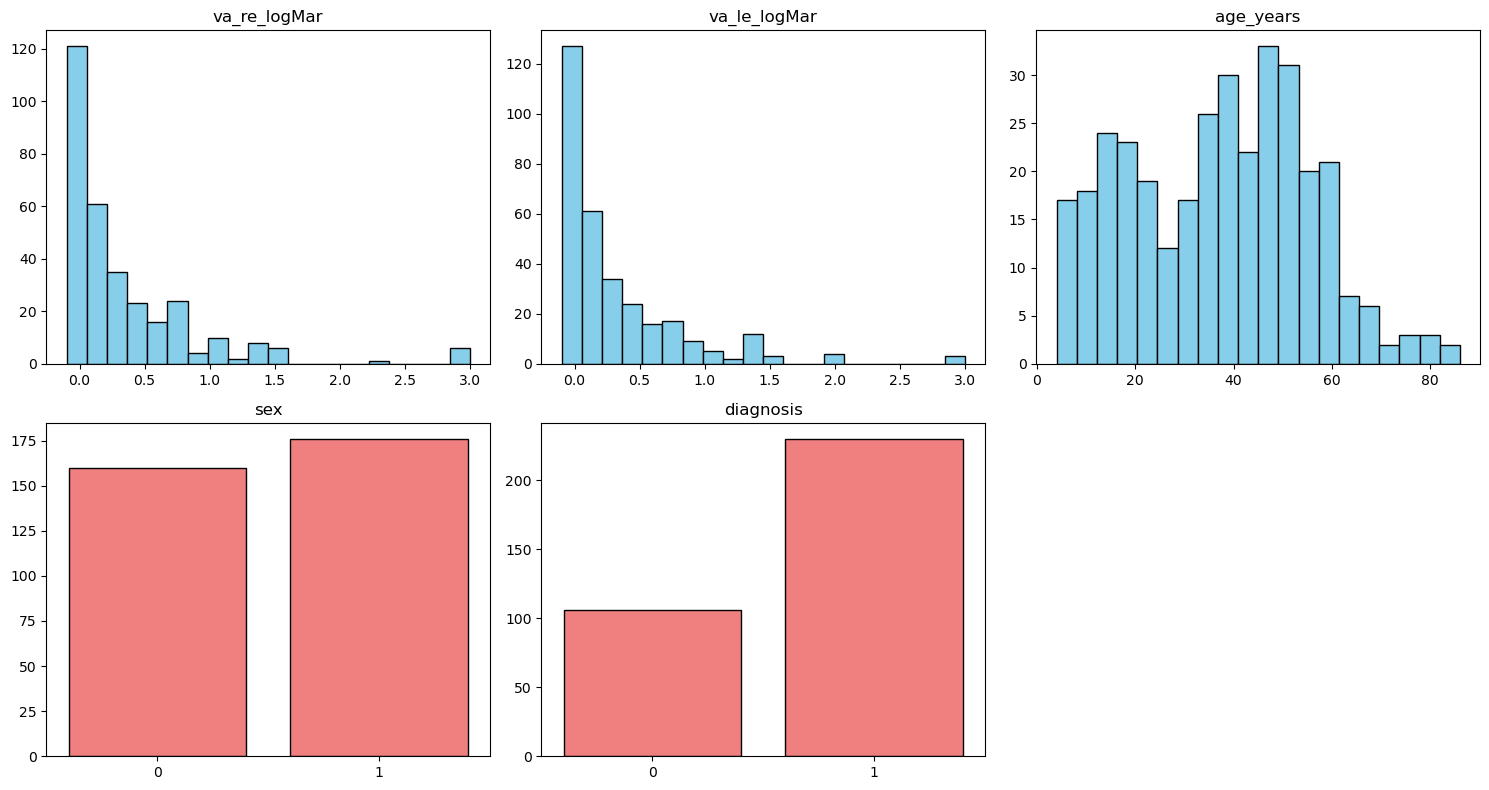

In [50]:
cols = ["va_re_logMar", "va_le_logMar", "age_years", "sex", "diagnosis"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    
    if results_df[col].dropna().nunique() == 2:
        counts = results_df[col].value_counts().sort_index()
        ax.bar(counts.index, counts.values, color='lightcoral', edgecolor='black')
        ax.set_xticks([0, 1])
        ax.set_xlim(-0.5, 1.5)
    else:
        results_df[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    
    ax.set_title(col)
    ax.grid(False)

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In the plots, we can see a slight imbalance in our target variable, as there are about twice as much daata points for an abnormal diagnosis as for a healthy diagnosis. This is an information we need to consider further in training and evaluation of our models. Furthermore, we can see the features "va_re_logMar" and "va_le_logMar" are right skewed, which we will keep in mind for our data preprocessing steps. 

### One-Hot Encode Unilateral Column

In [51]:
one_hot_unilateral = pd.get_dummies(data=results_df["unilateral"],dtype=int)
results_df.drop(columns=["unilateral"],inplace=True)
results_df = pd.concat(objs=[results_df, one_hot_unilateral],axis=1)
results_df.rename(columns={"LE": "unilateral_LE", "RE": "unilateral_RE"}, inplace=True)

results_df

,id_record,age_years,sex,diagnosis,va_re_logMar,va_le_logMar,unilateral_LE,unilateral_RE
0,1,13,0,0,-0.08,0.06,0,0
1,2,13,1,1,0.18,0.16,0,0
2,3,49,1,1,0.26,0.00,0,0
3,4,43,1,1,NaN,NaN,0,0
4,5,47,1,0,0.10,0.10,0,0
...,...,...,...,...,...,...,...,...
331,332,43,0,1,0.02,0.00,0,0
332,333,4,0,1,1.00,0.52,0,0
333,334,14,0,0,-0.10,-0.06,0,0
334,335,23,1,1,0.00,0.00,0,0


### Split off Target

In [52]:
y = results_df["diagnosis"]
X = results_df.drop(columns="diagnosis",axis=1)

In [53]:
y = y.astype(int)

### Merge single csv files into dataframe
-> used mean of every observation column, dropped time data

In [54]:
column_names = ["RE_1_mean", "LE_1_mean", "RE_2_mean", "LE_2_mean","RE_3_mean", "LE_3_mean", "RE_4_mean", "LE_4_mean", "RE_5_mean", "LE_5_mean"]

In [55]:
for c in column_names:
    X[c] = np.nan

X = X.set_index("id_record")
    
for key in features_df.keys():
    patient_id = int(key)
    for name in features_df[key].columns.values.tolist():
        mean_name = name + "_mean"
        if mean_name in column_names:
            X.loc[patient_id,mean_name] = round(features_df[key][name].mean(),4)
            

In [56]:
X

,age_years,sex,va_re_logMar,va_le_logMar,unilateral_LE,unilateral_RE,RE_1_mean,LE_1_mean,RE_2_mean,LE_2_mean,RE_3_mean,LE_3_mean,RE_4_mean,LE_4_mean,RE_5_mean,LE_5_mean
id_record,,,,,,,,,,,,,,,,
1,13,0,-0.08,0.06,0,0,-1.4067,1.8533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,1,0.18,0.16,0,0,-1.3404,-2.3765,-0.4447,-2.7773,NaN,NaN,NaN,NaN,NaN,NaN
3,49,1,0.26,0.00,0,0,-1.2949,0.3788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43,1,NaN,NaN,0,0,-1.6910,2.5114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,47,1,0.10,0.10,0,0,2.7255,1.5796,3.0612,1.7925,0.1580,1.2094,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,43,0,0.02,0.00,0,0,-0.1894,0.4902,-0.9400,-0.1071,-1.5208,-0.2267,NaN,NaN,NaN,NaN
333,4,0,1.00,0.52,0,0,-0.7024,-2.3616,-0.7659,-3.5039,NaN,NaN,NaN,NaN,NaN,NaN
334,14,0,-0.10,-0.06,0,0,-0.3420,0.6569,0.7718,-0.8761,NaN,NaN,NaN,NaN,NaN,NaN


### View shape of dataset

In [57]:
X.shape

(336, 16)

### Count NaN-values of every column


In [58]:
X.isna().sum()

age_years          0
sex                0
va_re_logMar      19
va_le_logMar      19
unilateral_LE      0
unilateral_RE      0
RE_1_mean          0
LE_1_mean          0
RE_2_mean         49
LE_2_mean         49
RE_3_mean        289
LE_3_mean        289
RE_4_mean        330
LE_4_mean        330
RE_5_mean        335
LE_5_mean        335
dtype: int64

### Drop examinations 3-5, if existant
We can observe that for the RE and LE 3-5 observations, most of the patients have NaN-values (meaning for most patients there are only two measurements). Therfore, we will eliminate the examinations 3-5.

In [59]:
X = X.drop(columns=["RE_3_mean", "LE_3_mean", "RE_4_mean", "LE_4_mean", "RE_5_mean", "LE_5_mean"])

### Add median features

In [60]:
column_names = ['RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']

for c in column_names:
    X[c] = np.nan

for key in features_df.keys():
    patient_id = int(key)
    for name in features_df[key].columns.values.tolist():
        median_name = name + "_median"
        if median_name in column_names:
            X.loc[patient_id,median_name] = round(features_df[key][name].median(),4)

In [61]:
X

,age_years,sex,va_re_logMar,va_le_logMar,unilateral_LE,unilateral_RE,RE_1_mean,LE_1_mean,RE_2_mean,LE_2_mean,RE_1_median,RE_2_median,LE_1_median,LE_2_median
id_record,,,,,,,,,,,,,,
1,13,0,-0.08,0.06,0,0,-1.4067,1.8533,NaN,NaN,-1.6,NaN,1.3,NaN
2,13,1,0.18,0.16,0,0,-1.3404,-2.3765,-0.4447,-2.7773,-1.2,-0.5,-2.9,-3.0
3,49,1,0.26,0.00,0,0,-1.2949,0.3788,NaN,NaN,-1.7,NaN,0.4,NaN
4,43,1,NaN,NaN,0,0,-1.6910,2.5114,NaN,NaN,-1.6,NaN,2.1,NaN
5,47,1,0.10,0.10,0,0,2.7255,1.5796,3.0612,1.7925,3.1,3.1,1.4,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,43,0,0.02,0.00,0,0,-0.1894,0.4902,-0.9400,-0.1071,-0.1,-0.7,0.7,0.0
333,4,0,1.00,0.52,0,0,-0.7024,-2.3616,-0.7659,-3.5039,-0.8,-0.4,-2.9,-2.7
334,14,0,-0.10,-0.06,0,0,-0.3420,0.6569,0.7718,-0.8761,-0.6,0.3,0.3,-0.9


### Treat NaN-Values by KNN impute

In [62]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
X[:]= imputer.fit_transform(X)
X

,age_years,sex,va_re_logMar,va_le_logMar,unilateral_LE,unilateral_RE,RE_1_mean,LE_1_mean,RE_2_mean,LE_2_mean,RE_1_median,RE_2_median,LE_1_median,LE_2_median
id_record,,,,,,,,,,,,,,
1,13,0,-0.080,0.060,0,0,-1.4067,1.8533,0.77720,-0.58982,-1.6,0.76,1.3,-0.72
2,13,1,0.180,0.160,0,0,-1.3404,-2.3765,-0.44470,-2.77730,-1.2,-0.50,-2.9,-3.00
3,49,1,0.260,0.000,0,0,-1.2949,0.3788,-0.09372,0.00166,-1.7,-0.26,0.4,-0.24
4,43,1,0.136,0.444,0,0,-1.6910,2.5114,-0.99052,0.17732,-1.6,-0.98,2.1,0.12
5,47,1,0.100,0.100,0,0,2.7255,1.5796,3.06120,1.79250,3.1,3.10,1.4,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,43,0,0.020,0.000,0,0,-0.1894,0.4902,-0.94000,-0.10710,-0.1,-0.70,0.7,0.00
333,4,0,1.000,0.520,0,0,-0.7024,-2.3616,-0.76590,-3.50390,-0.8,-0.40,-2.9,-2.70
334,14,0,-0.100,-0.060,0,0,-0.3420,0.6569,0.77180,-0.87610,-0.6,0.30,0.3,-0.90


In [63]:
X.isna().sum()

age_years        0
sex              0
va_re_logMar     0
va_le_logMar     0
unilateral_LE    0
unilateral_RE    0
RE_1_mean        0
LE_1_mean        0
RE_2_mean        0
LE_2_mean        0
RE_1_median      0
RE_2_median      0
LE_1_median      0
LE_2_median      0
dtype: int64

### Transformations necessary?
Here, we are having another look at the distributions of our features to check which transformations we can/should apply in the next step.

In [64]:
X.describe()

,age_years,sex,va_re_logMar,va_le_logMar,unilateral_LE,unilateral_RE,RE_1_mean,LE_1_mean,RE_2_mean,LE_2_mean,RE_1_median,RE_2_median,LE_1_median,LE_2_median
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,37.071429,0.523810,0.333446,0.316173,0.011905,0.011905,-0.453532,-0.237411,-0.462046,-0.247416,-0.537202,-0.518869,-0.300893,-0.293452
std,18.284182,0.500178,0.533141,0.489216,0.108619,0.108619,1.850408,2.197395,1.762293,1.835253,1.898676,1.762296,2.168258,1.872121
min,4.000000,0.000000,-0.100000,-0.100000,0.000000,0.000000,-11.142000,-12.962400,-8.316100,-5.903900,-11.700000,-8.600000,-11.500000,-6.300000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.416225,-1.267475,-1.301075,-1.146525,-1.500000,-1.300000,-1.300000,-1.150000
50%,38.000000,1.000000,0.160000,0.140000,0.000000,0.000000,-0.440750,-0.260200,-0.448200,-0.444080,-0.500000,-0.500000,-0.200000,-0.440000
75%,51.000000,1.000000,0.445000,0.448000,0.000000,0.000000,0.419800,0.561000,0.291100,0.590950,0.200000,0.185000,0.500000,0.400000
max,86.000000,1.000000,3.000000,3.000000,1.000000,1.000000,7.735300,13.211800,10.913700,11.239200,8.200000,11.100000,11.700000,11.800000


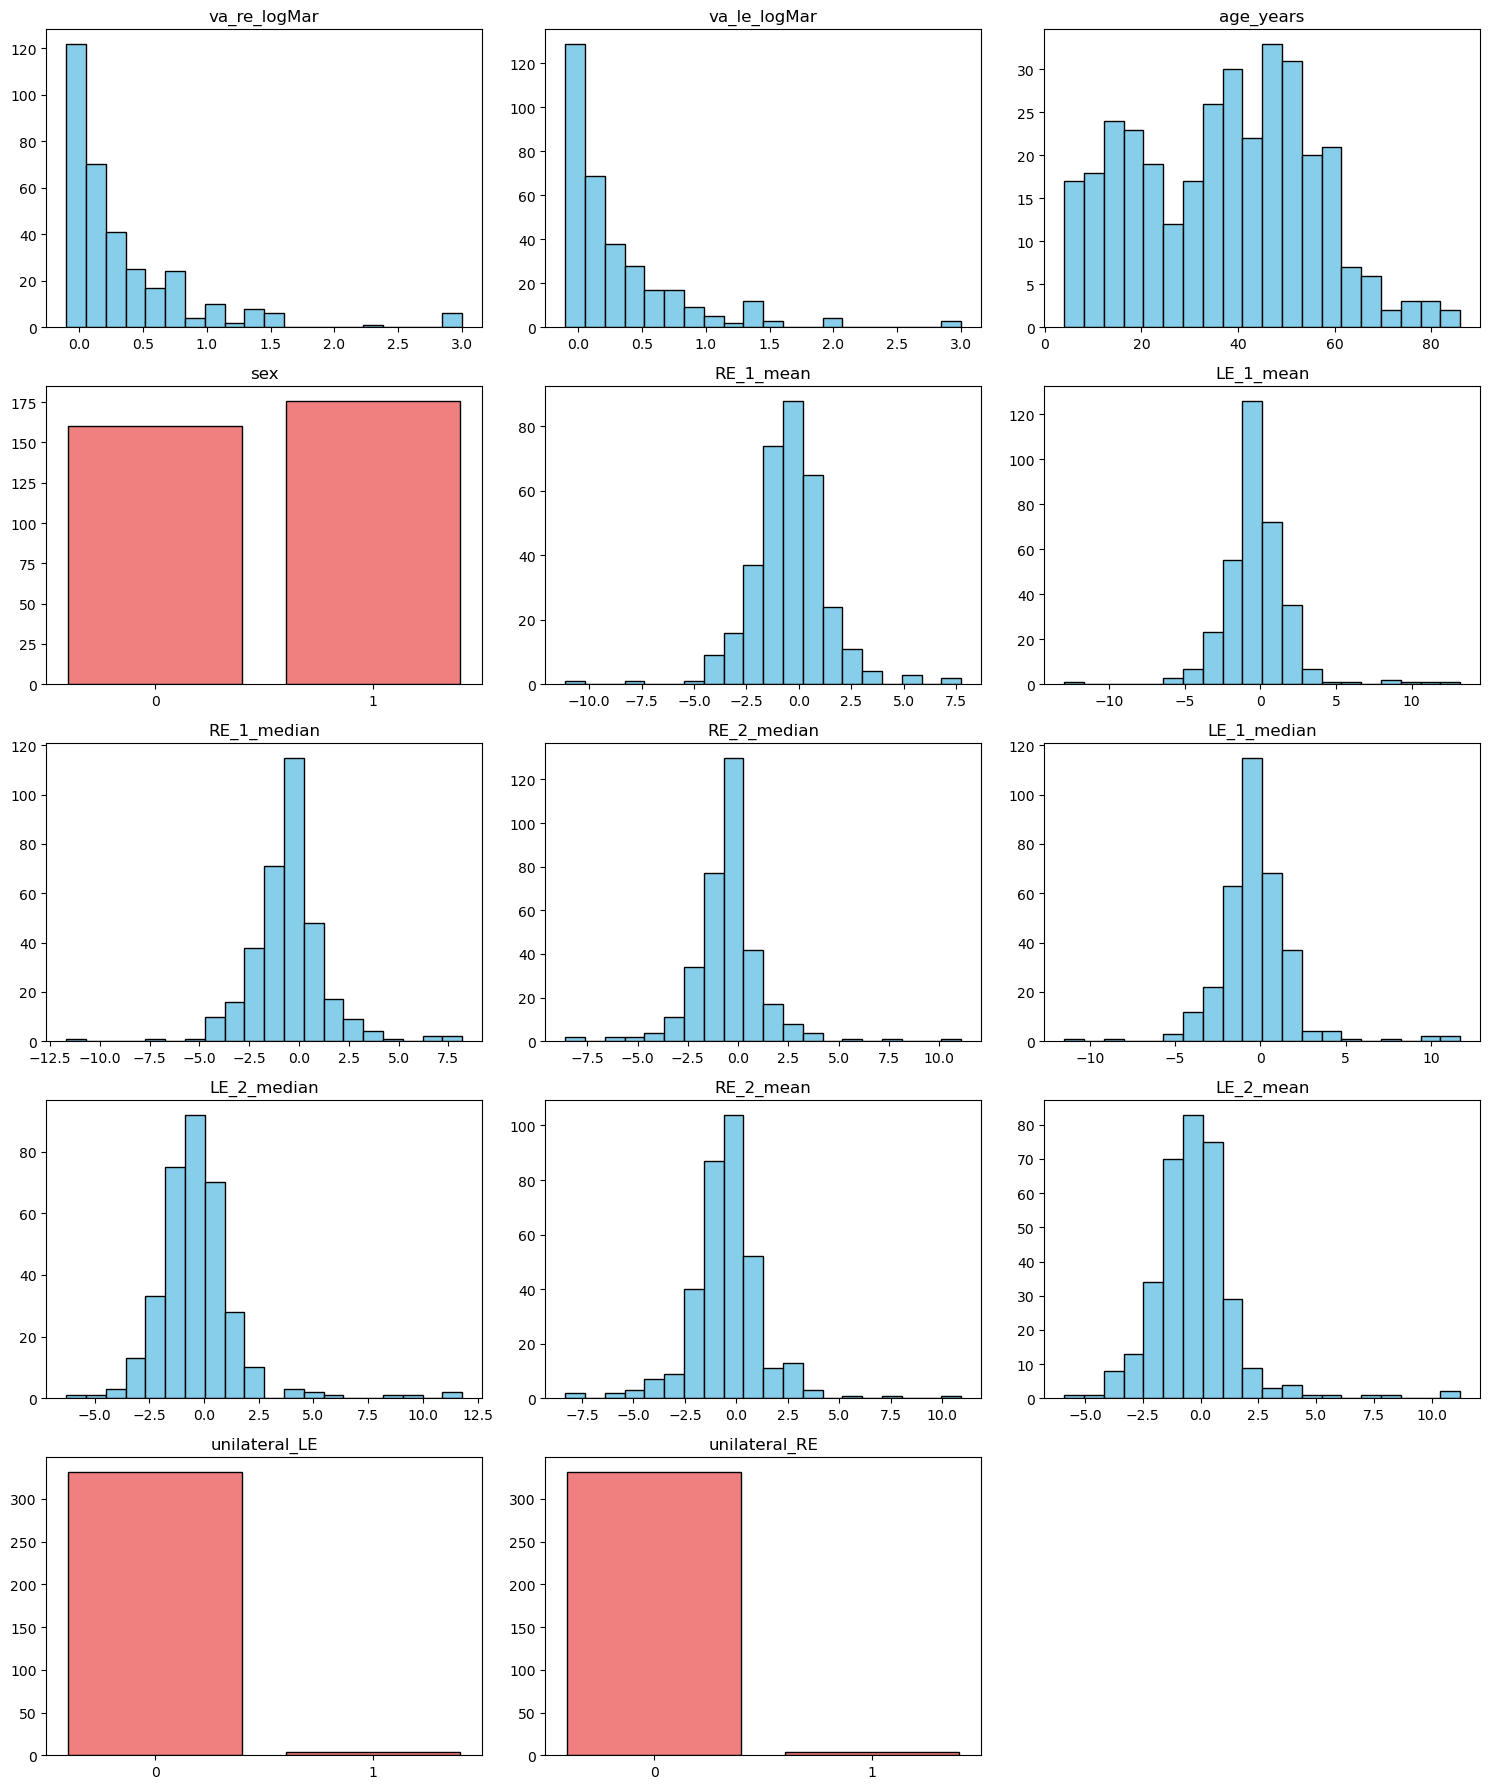

In [65]:
cols = ["va_re_logMar", "va_le_logMar", "age_years", "sex", "RE_1_mean", "LE_1_mean",'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median', "RE_2_mean", "LE_2_mean", "unilateral_LE", "unilateral_RE"]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    
    if X[col].dropna().nunique() == 2:
        counts = results_df[col].value_counts().sort_index()
        ax.bar(counts.index, counts.values, color='lightcoral', edgecolor='black')
        ax.set_xticks([0, 1])
        ax.set_xlim(-0.5, 1.5)
    else:
        X[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    
    ax.set_title(col)
    ax.grid(False)

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on these histograms, I chose Standard-Scaler transformations for most of the numerical variables, but a Yeo-Johnson transformation for the features "va_re_logMar" and "va_le_logMar", as they are right skewed. To avoid leakage, at this point only the preprocessor is defined and I will perform the actual scalings within the cross-validation pipeline.

### Transformations

In [70]:
power_features = ["va_re_logMar", "va_le_logMar"]
scaler_features = ["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']
preprocessor = ColumnTransformer(transformers=[
    ('power', PowerTransformer(), power_features),
    ('scaler', StandardScaler(), scaler_features)
])

## Train Test Split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [72]:
accuracy = {}
f1 = {}
sensitivity = {}
specifity = {}
fnr = {}
fpr = {}
conf_mat = {}
y_probs = {}

## Supervised Learning - Simple Technique

I am testing two rather simple techniques: Random Forest Classifier and SVC. Since the classes are slightly imbalanced, I run a second training round with oversampled classes by using SMOTE to compare the results to the normal training data.
I am using a stratified K-Fold for cross validation and Grid Search to tune the parameters. As score metric for grid search, F1 is used for imbalance reasons.

### Random Forest without SMOTE oversampling

In [75]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', rfc)
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 2, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt'],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced'],
    'clf__random_state':  [0]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred_test = best_rf.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["rfc"] = accuracy_score(y_test, y_pred_test)
f1["rfc"] = f1_score(y_test, y_pred_test)
sensitivity["rfc"] = recall_score(y_test, y_pred_test)
specifity["rfc"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["rfc"] = fn/(tp+fn)
fpr["rfc"] = fp/(fp+tn) 
conf_mat["rfc"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["rfc"] = best_rf.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

F1-score: 0.7704918032786885
Best parameter combinations from Grid Search: {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200, 'clf__random_state': 0}


### Random Forest with SMOTE oversampling

In [76]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('preprocessing', preprocessor),
    ('clf', rfc)
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 2, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt'],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced'],
    'clf__random_state':  [0]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_rf_sm = grid_search.best_estimator_

y_pred_test = best_rf_sm.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["rfc_sm"] = accuracy_score(y_test, y_pred_test)
f1["rfc_sm"] = f1_score(y_test, y_pred_test)
sensitivity["rfc_sm"] = recall_score(y_test, y_pred_test)
specifity["rfc_sm"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["rfc_sm"] = fn/(tp+fn)
fpr["rfc_sm"] = fp/(fp+tn) 
conf_mat["rfc_sm"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["rfc_sm"] = best_rf.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

F1-score: 0.7155963302752294
Best parameter combinations from Grid Search: {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'clf__random_state': 0}


### SVC without SMOTE oversampling

In [77]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc = SVC()

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', svc)
])

param_grid = {
    'clf__C':[0.1, 1, 10, 100],
    'clf__gamma':['scale', 'auto',0.1], 
    'clf__kernel':['linear', 'rbf'], 
    'clf__class_weight': ['balanced'], 
    'clf__probability':[True],
    'clf__random_state': [0]
}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_

y_pred_test = best_svc.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["svc"] = accuracy_score(y_test, y_pred_test)
f1["svc"] = f1_score(y_test, y_pred_test)
sensitivity["svc"] = recall_score(y_test, y_pred_test)
specifity["svc"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["svc"] = fn/(tp+fn)
fpr["svc"] = fp/(fp+tn) 
conf_mat["svc"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["svc"] = best_svc.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

F1-score: 0.6736842105263158
Best parameter combinations from Grid Search: {'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'clf__probability': True, 'clf__random_state': 0}


### SVC with SMOTE oversampling

In [78]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc = SVC()

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('preprocessing', preprocessor),
    ('clf', svc)
])

param_grid = {
    'clf__C':[0.1, 1, 10, 100],
    'clf__gamma':['scale', 'auto',0.1], 
    'clf__kernel':['linear', 'rbf'], 
    'clf__class_weight': ['balanced'], 
    'clf__probability':[True],
    'clf__random_state': [0]
}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_svc_sm = grid_search.best_estimator_

y_pred_test = best_svc_sm.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["svc_sm"] = accuracy_score(y_test, y_pred_test)
f1["svc_sm"] = f1_score(y_test, y_pred_test)
sensitivity["svc_sm"] = recall_score(y_test, y_pred_test)
specifity["svc_sm"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["svc_sm"] = fn/(tp+fn)
fpr["svc_sm"] = fp/(fp+tn) 
conf_mat["svc_sm"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["svc_sm"] = best_svc.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

F1-score: 0.7142857142857143
Best parameter combinations from Grid Search: {'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'clf__probability': True, 'clf__random_state': 0}


## Supervised Learning - Complex Technique

For the complex technique, I have implemented a MLP Classifier. I am also using cross validation with stratified K-Fold and Grid Search with F1 scoring. Furthermore, oversampling with SMOTE is also implemented.

### MLP without SMOTE oversampling

In [79]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp = MLPClassifier()

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', mlp)
])

param_grid = {
    'clf__hidden_layer_sizes': [(10,), (20,), (30,), (20, 10)], 
    'clf__activation': ['relu', 'tanh'],                   
    'clf__solver': ['adam'],                               
    'clf__alpha': [0.0001, 0.001, 0.01],                   
    'clf__learning_rate_init': [0.001, 0.01],              
    'clf__max_iter': [300]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

y_pred_test = best_mlp.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["mlp"] = accuracy_score(y_test, y_pred_test)
f1["mlp"] = f1_score(y_test, y_pred_test)
sensitivity["mlp"] = recall_score(y_test, y_pred_test)
specifity["mlp"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["mlp"] = fn/(tp+fn)
fpr["mlp"] = fp/(fp+tn) 
conf_mat["mlp"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["mlp"] = best_mlp.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

F1-score: 0.6476190476190476
Best parameter combinations from Grid Search: {'clf__activation': 'tanh', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (30,), 'clf__learning_rate_init': 0.01, 'clf__max_iter': 300, 'clf__solver': 'adam'}


/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP with SMOTE oversampling

In [80]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp = MLPClassifier()

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('preprocessing', preprocessor),
    ('clf', mlp)
])

param_grid = {
    'clf__hidden_layer_sizes': [(10,), (20,), (30,), (20, 10)], 
    'clf__activation': ['relu', 'tanh'],                   
    'clf__solver': ['adam'],                               
    'clf__alpha': [0.0001, 0.001, 0.01],                   
    'clf__learning_rate_init': [0.001, 0.01],              
    'clf__max_iter': [300]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train, y_train)
best_mlp_sm = grid_search.best_estimator_

y_pred_test = best_mlp_sm.predict(X_test)

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
accuracy["mlp_sm"] = accuracy_score(y_test, y_pred_test)
f1["mlp_sm"] = f1_score(y_test, y_pred_test)
sensitivity["mlp_sm"] = recall_score(y_test, y_pred_test)
specifity["mlp_sm"] = recall_score(y_test, y_pred_test, pos_label=0)
fnr["mlp_sm"] = fn/(tp+fn)
fpr["mlp_sm"] = fp/(fp+tn) 
conf_mat["mlp_sm"] = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
y_probs["mlp_sm"] = best_mlp.predict_proba(X_test)[:, 1]

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

F1-score: 0.7433628318584071
Best parameter combinations from Grid Search: {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (20, 10), 'clf__learning_rate_init': 0.01, 'clf__max_iter': 300, 'clf__solver': 'adam'}


## Feature Importances / Explainability

### Permutation Feature Importances

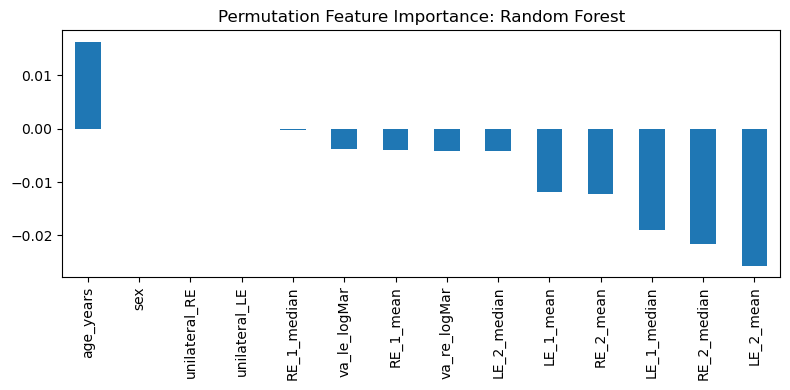

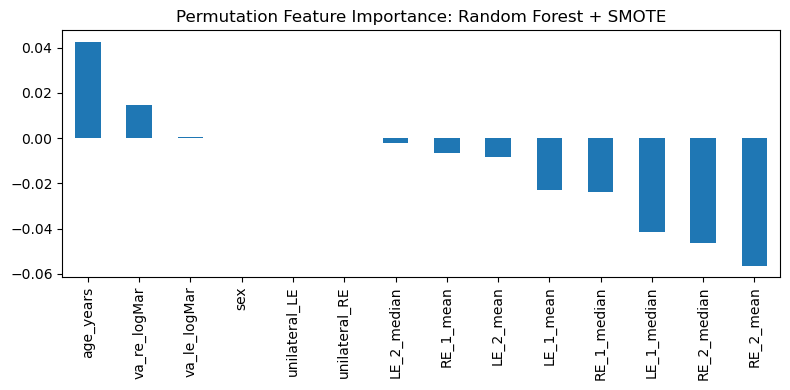

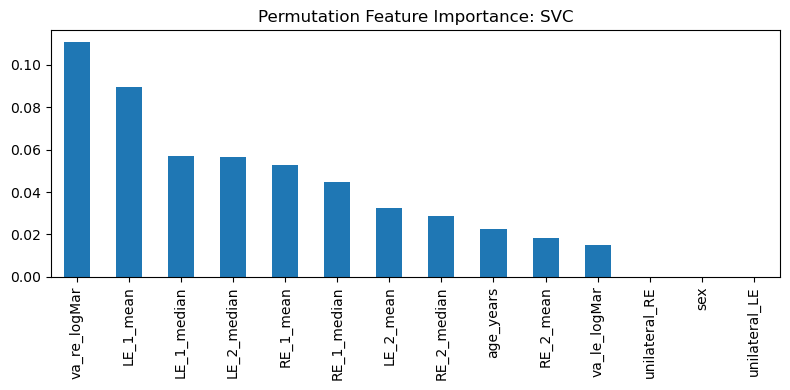

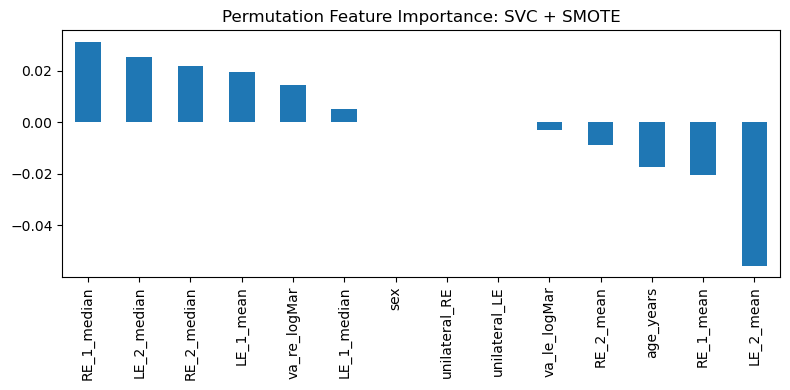

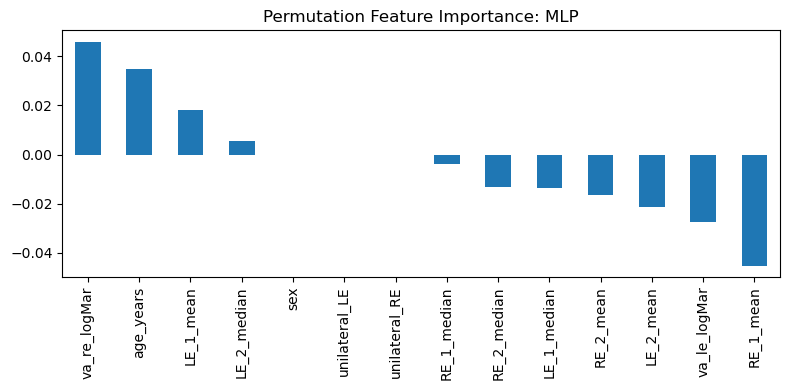

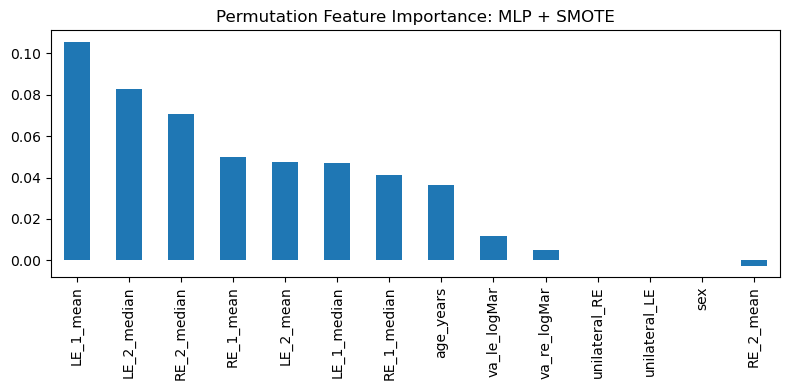

In [81]:
models = [best_rf, best_rf_sm, best_svc, best_svc_sm, best_mlp, best_mlp_sm]
model_names = ['Random Forest', 'Random Forest + SMOTE', 'SVC', 'SVC + SMOTE', 'MLP', 'MLP + SMOTE']

for model, name in zip(models, model_names):
    result = permutation_importance(model, X_test, y_test, scoring='f1', n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

    plt.figure(figsize=(8, 4))
    importances.plot(kind='bar')
    plt.title(f'Permutation Feature Importance: {name}')
    plt.tight_layout()
    plt.show() 

Looking at feature importances, for SVC and Random Forest, the age of the patient seemed to be most relevant for the decisions, while for example sex barely or not at all contributed any information. For MLP, va_re_logMar was the most important feature. The most interesting takeaway from this is probably that the gender of the patient does not seem to contribute much or sometimes even any information in all of the models.

## Result Metrics

In [82]:
metrics_df = pd.DataFrame({
    "Accuracy": accuracy,
    "F1 Score": f1,
    "Sensitivity (Recall)": sensitivity,
    "Specificity": specifity,
    "FNR": fnr,
    "FPR": fpr
})

metrics_df

,Accuracy,F1 Score,Sensitivity (Recall),Specificity,FNR,FPR
rfc,0.666667,0.770492,0.839286,0.321429,0.160714,0.678571
rfc_sm,0.630952,0.715596,0.696429,0.500000,0.303571,0.500000
svc,0.630952,0.673684,0.571429,0.750000,0.428571,0.250000
svc_sm,0.619048,0.714286,0.714286,0.428571,0.285714,0.571429
mlp,0.559524,0.647619,0.607143,0.464286,0.392857,0.535714
mlp_sm,0.654762,0.743363,0.750000,0.464286,0.250000,0.535714


Since we are dealing with an imbalanced problem, I want to focus on F1 as the main evaluation metric. This is not as sensitive to imbalanced classes as accuracy. Looking at the F1 scores, Random Forest performed best overall with a score of 77%. The oversampled versions of MLP (74%) and SVC (71%) also performed relatively good. It can be observed that oversampling improves the results for SVC and MLP, but worsens the results of RFC.

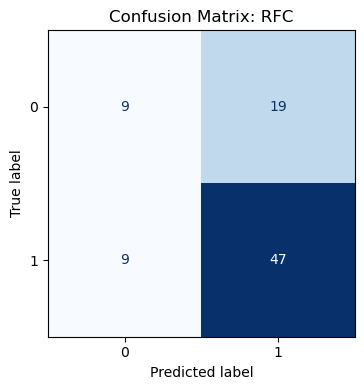

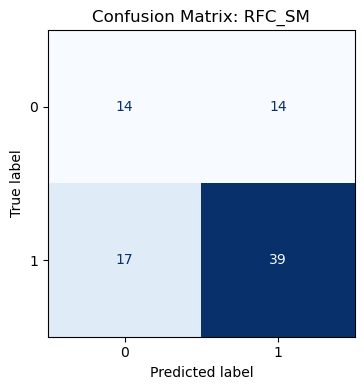

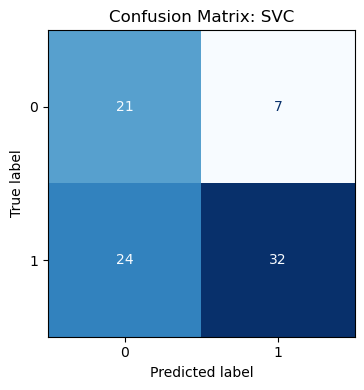

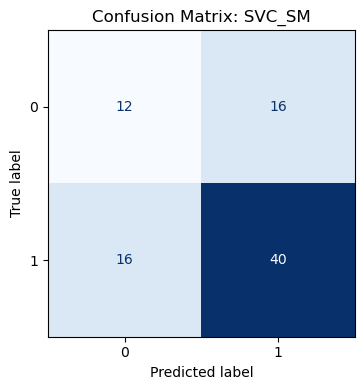

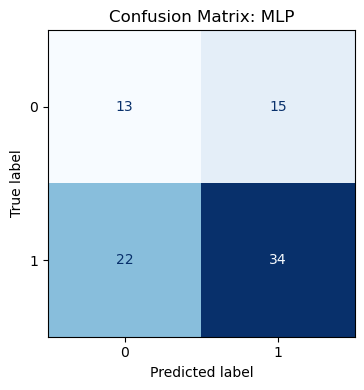

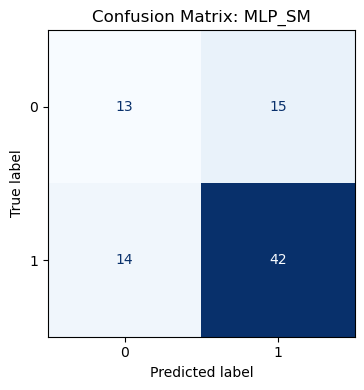

In [83]:
# confusion matrix
for clf_name, cm in conf_mat.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix: {clf_name.upper()}")
    plt.tight_layout()
    plt.show()

Looking at the Confusion Matrixes, we can seemingly observe the Classifiers preferring the class label "1", especially with RFC. This might be due to the imbalance of the classes, as we can see this error shifts to a misclassification of 1-classes when the classes are oversampled with SMOTE. Before oversampling, many data points of class "0" are often classified wrong, meaning many helthy patients are predicted to have some kind of diagnosis. After oversampling, less healthy patients are misclassified, but more unhealty patients are predicted to be sick.

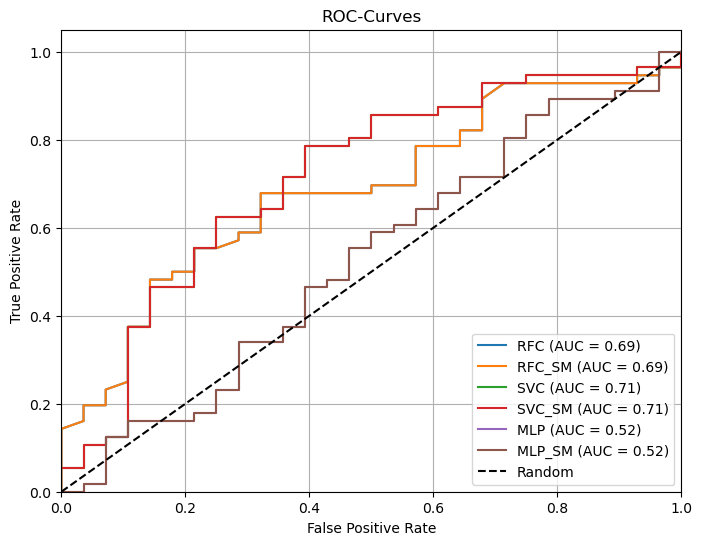

In [85]:
# roc curve
plt.figure(figsize=(8, 6))

for clf_name, probs in y_probs.items():
    fpr_, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr_, tpr)
    plt.plot(fpr_, tpr, label=f"{clf_name.upper()} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The ROC-Curves show good results for SVC. 

## K-Means Clustering

### Feature Scaling (same as before)

In [86]:
X_scaled = X.copy()

pt = PowerTransformer()
X_scaled[["va_re_logMar", "va_le_logMar"]] = pt.fit_transform(X[["va_re_logMar", "va_le_logMar"]])

scaler = StandardScaler()
X_scaled[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']] = scaler.fit_transform(X[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']])

### Clustering

In [87]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

### PCA and visualization of clustering (left) and ground truth (right)

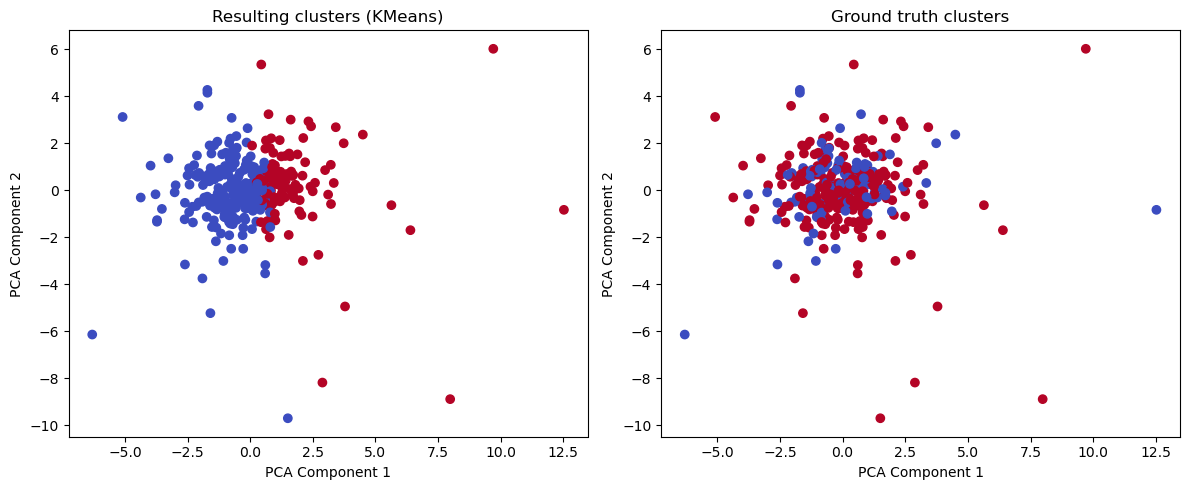

In [88]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='coolwarm')
axes[0].set_title("Resulting clusters (KMeans)")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
axes[1].set_title("Ground truth clusters")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

In [89]:
sil_score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", round(sil_score, 3))

Silhouette Score: 0.168


By only looking at the visual clustering of KMeans and ignoring the Ground Truth, we can already see that there is not a clear separation of the two classes, the clusters are very close to eachother and seem to overlap. The silhouette score underlines this observation, as it is very low and signals a bad clustering. If we look at the Ground Truth clusters, we can see that the two classes are mixed and overlapping completely, showing a difficulty in keeping the two classes clustered apart.

### Adjusted Rand Score to evaluate results by KMeans
The ARI has a range of -1 to +1. We can observe a negative ARI in this case, showing that KMeans did not perform well in clustering the two classes.

In [90]:
ari_score = adjusted_rand_score(y, clusters)
print("ARI:", round(ari_score, 3))

ARI: -0.013


## Autoencoder for feature extraction

### Feature scaling

In [91]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

pt = PowerTransformer()
X_train_scaled[["va_re_logMar", "va_le_logMar"]] = pt.fit_transform(X_train_scaled[["va_re_logMar", "va_le_logMar"]])
X_test_scaled[["va_re_logMar", "va_le_logMar"]] = pt.fit_transform(X_test_scaled[["va_re_logMar", "va_le_logMar"]])

scaler = StandardScaler()
X_train_scaled[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']] = scaler.fit_transform(X_train_scaled[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']])
X_test_scaled[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']] = scaler.fit_transform(X_test_scaled[["age_years", "RE_1_mean", "RE_2_mean", "LE_1_mean", "LE_2_mean", 'RE_1_median', 'RE_2_median', 'LE_1_median', 'LE_2_median']])

### Define and train autoencoder

In [92]:
# input dimension is number of features
input_dim = X.shape[1]

# encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)  

# decoder
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50


2025-06-29 23:05:41.347316: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7470 - val_loss: 0.5374
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7928 - val_loss: 0.5144
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6941 - val_loss: 0.4920
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6952 - val_loss: 0.4676
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8207 - val_loss: 0.4402
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6238 - val_loss: 0.4131
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5759 - val_loss: 0.3811
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5186 - val_loss: 0.3387
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4516 - val_loss: 0.3044
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3747 - val_loss: 0.2865
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3119 - val_loss: 0.2568
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2531 - val_loss: 0.2066
Epoch 13/50
8/8 ━━━━━━━

In [94]:
X_train_encoded = autoencoder.predict(X_train_scaled)
X_test_encoded = autoencoder.predict(X_test_scaled)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


### Training of RF and MLP with autoencoder features
For the scope of this project, I will only test the autoencoder features on the two methods Random Forest and MLP without SMOTE oversampling.

In [97]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced'],
    'random_state':  [0]
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train_encoded, y_train)
best_rf = grid_search.best_estimator_

y_pred_test = best_rf.predict(X_test_encoded)

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_test)}")
print(f"Specificity: {recall_score(y_test, y_pred_test, pos_label=0)}")
print(f"FNR: {fn/(tp+fn)}")
print(f"FPR: {fp/(fp+tn)}") 

Best parameter combinations from Grid Search: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 0}
F1-score: 0.78125
Accuracy: 0.6666666666666666
Sensitivity: 0.8928571428571429
Specificity: 0.21428571428571427
FNR: 0.10714285714285714
FPR: 0.7857142857142857


For Random Forest, feature extraction with an autoencoder results in only a slight improvement (F1-score of 78% instead of previously 77%).

In [98]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (20, 10)], 
    'activation': ['relu', 'tanh'],                   
    'solver': ['adam'],                               
    'alpha': [0.0001, 0.001, 0.01],                   
    'learning_rate_init': [0.001, 0.01],              
    'max_iter': [300]
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=kf, scoring='f1')
grid_search.fit(X_train_encoded, y_train)
best_rf = grid_search.best_estimator_

y_pred_test = best_rf.predict(X_test_encoded)

print(f"Best parameter combinations from Grid Search: {grid_search.best_params_}")

print(f"F1-score: {f1_score(y_test, y_pred_test)}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_test)}")
print(f"Specificity: {recall_score(y_test, y_pred_test, pos_label=0)}")
print(f"FNR: {fn/(tp+fn)}")
print(f"FPR: {fp/(fp+tn)}") 

/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

Best parameter combinations from Grid Search: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'adam'}
F1-score: 0.8062015503875969
Accuracy: 0.7023809523809523
Sensitivity: 0.9285714285714286
Specificity: 0.25
FNR: 0.07142857142857142
FPR: 0.75


/home/luca/anaconda3/envs/ai4h/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


For MLP on the other hand, the autoencoder brings a great improvement looking at F1. It was elevated to almost 81% from previously 65%!